# 03_anchor_generator
**This file used to generate anchors for UECFOOD100 dataset through kmeans.
Distance here is not Euclidean distance but IoU (Intersection over Union) in
accordance with original yolo-v2 paper.**

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np

**k-means clustering**:  
- Input: k, set of points [w1,h1], [w2,h2], [w3, h3], ..., [wn, hn] 
- Place centroids c1, ..., ck at random locations (randomly select k [w,h] among input img wh)
- Repeat until convergence:
    - for each point [wi,hi]:
        - find nearest centroid cj. (np.argmin(new_distances, axis=1))
        - assign the point [wi,hi] to cluster j.
    - for each cluster j=1, ...,k: (update centroids)
        - new centroid cj=mean of all points [wi,hi] assigned to cluster j in previous step
        $\frac{1}{n_j}\sum\limits_{x_i\rightarrow c_j}x_i(a)$  (a means a particular attribute in this case a is wh[i])
- Stop when none of the cluster assignments change

In [2]:
def kmeans(wh, centroids, anchor_txt):
    num = wh.shape[0]  # total number of different wh pairs
    k, dim = centroids.shape
    iter = 0
    old_distances = np.zeros((num, k))
    _assignments = -np.ones(num)

    # iterate until
    while True:
        new_distances = []
        iter += 1
        for i in range(num):
            distance = 1 - IoU(wh[i], centroids)  # high IoU represents low distance
            new_distances.append(distance)
        new_distances = np.array(new_distances)
        print('Iter {}: distances: {}'.format(iter, np.sum((np.abs(old_distances - new_distances)))))

        # for each input img assign a centroid (select the closed one)
        assignments = np.argmin(new_distances, axis=1)
        if (assignments == _assignments).all():
            print('final centroids =', centroids)
            save_anchors(centroids, anchor_txt, wh_in_yolov2)
            return centroids
        else:
            centroid_sums = np.zeros((k, dim), np.float)
            for i in range(num):
                centroid_sums[assignments[i]] += wh[i]  # sum up attribute
            for j in range(k):
                # new centroids
                centroids[j] = centroid_sums[j] / np.sum(assignments == j)

            _assignments = assignments.copy()
            old_distances = new_distances.copy()

In [3]:
def save_anchors(centroids, anchor_txt, wh_in_yolov2):
    width_in_yolov2 = wh_in_yolov2[0]
    height_in_yolov2 = wh_in_yolov2[1]
    with open(anchor_txt, 'w') as file:
        anchors = centroids.copy()
        for i in range(anchors.shape[0]):
            anchors[i][0] *= width_in_yolov2 / 32.
            anchors[i][1] *= height_in_yolov2 / 32.
        widths = anchors[:, 0]
        sorted_indices = np.argsort(widths)  # return the indices that sort tht array
        print('anchors = ', anchors[sorted_indices])

        for i in sorted_indices:
            file.write('%0.2f, %0.2f\n' % (anchors[i, 0], anchors[i, 1]))

In [4]:
def avgIoU(wh, centroids):
    sum = 0.
    for i in range(wh.shape[0]):
        sum += max(IoU(wh[i], centroids))
    return sum / wh.shape[0]

**IoU - Intersection over Union **

In [5]:
def IoU(whi, centroids):
    """ Calculate IoU between current centroids with one in wh array to check if current
    centroids are suitable enough
    :param whi:
    :param centroids:
    :return:
    """
    IOU = []
    for centroid in centroids:
        c_w, c_h = centroid
        w, h = whi
        if c_w >= w and c_h >= h:
            iou = w * h / (c_w * c_h)
        elif c_w >= w and c_h <= h:
            iou = w * c_h / (w * h + (c_w - w) * c_h)
        elif c_w <= w and c_h >= h:
            iou = c_w * h / (w * h + (c_h - h) * c_w)
        else:
            iou = c_w * c_h / (w * h)
        IOU.append(iou)
    return np.array(IOU)

In [6]:
def coordinate2wh(coordinates, uec100_dims):
    coordinates = list(map(float, coordinates))
    w = (coordinates[2] - coordinates[0]) / uec100_dims[0]  # x2-x1
    h = (coordinates[3] - coordinates[1]) / uec100_dims[0]  # y2-y1
    return w, h

In [7]:
def gen_anchors(n_clusters, uec100_dims):
    dataset_disk = '/Volumes/JS/UECFOOD100_JS/'
    output_path = dataset_disk + 'generated_anchors'
    train_uec100 = dataset_disk + 'train_uec100.txt'

    if not os.path.exists(output_path):
        os.mkdir(output_path)

    wh = []

    with open(train_uec100, 'r') as file:
        for i, line in enumerate(file):
            if i > 0:
                line = line.rstrip('\n')
                line = line.split(' ')
                coordinates = line[2:]
                w, h = coordinate2wh(coordinates, uec100_dims)
                wh.append([w, h])
        wh = np.array(wh)

        if n_clusters == 0:  # make from 1 to 10 clusters and pick the best one
            avgIou = []
            for n_cluster in range(1, 11):
                anchor_txt = os.path.join(output_path, 'anchors_%d.txt' % (n_cluster))
                # randomly select n_cluster anchors from wh array which contain w,h for each img
                indices = [random.randrange(wh.shape[0]) for i in range(n_cluster)]
                centroids = wh[indices]
                centroids = kmeans(wh, centroids, anchor_txt)
                avgIou.append([n_cluster, avgIoU(wh, centroids)])
            avgIou = np.array(avgIou)
            plt.plot(avgIou[:, 0], avgIou[:, 1])
            plt.scatter(avgIou[:, 0], avgIou[:, 1], c='r')
            plt.xlabel('number of cluster')
            plt.ylabel('average IoU')
            plt.savefig('avg_iou')
            plt.show()
        else:
            anchor_txt = os.path.join(output_path, 'anchors_%d.txt' % (n_clusters))
            # randomly select n_cluster anchors from wh array which contain w,h for each img
            indices = [random.randrange(wh.shape[0]) for i in range(n_clusters)]
            centroids = wh[indices]
            kmeans(wh, centroids, anchor_txt)

        print('Done!')

In [8]:
wh_in_yolov2 = [416, 416]
uec100_dims = [800, 600]  # dataset image width=800, height=600
n_clusters = 0

Iter 1: distances: 4389.10515781336
Iter 2: distances: 1733.5194923078288
final centroids = [[0.77076476 0.55990102]]
anchors =  [[10.01994186  7.27871324]]
Iter 1: distances: 11308.181303340069
Iter 2: distances: 2255.4151677458726
Iter 3: distances: 802.9881414977824
Iter 4: distances: 440.47353135642584
Iter 5: distances: 267.91486238370715
Iter 6: distances: 133.03404092656532
Iter 7: distances: 90.224726364845
Iter 8: distances: 44.91173683436023
Iter 9: distances: 36.794570050161155
Iter 10: distances: 16.792880493922073
Iter 11: distances: 12.947628102709551
Iter 12: distances: 1.4480688527985448
Iter 13: distances: 2.626058049454606
Iter 14: distances: 5.023404236772478
Iter 15: distances: 2.525654627866509
Iter 16: distances: 1.2838021048495243
final centroids = [[0.87776497 0.63054291]
 [0.45723031 0.35290454]]
anchors =  [[ 5.94399401  4.58775899]
 [11.41094467  8.19705789]]
Iter 1: distances: 14907.0797349
Iter 2: distances: 2158.028786687689
Iter 3: distances: 665.02866359

Iter 69: distances: 4.778883368648029
Iter 70: distances: 2.259804036136685
Iter 71: distances: 2.315722666494099
Iter 72: distances: 2.3208639840808645
Iter 73: distances: 3.1368753591761576
Iter 74: distances: 2.535275040446449
final centroids = [[0.92431774 0.51466609]
 [0.30380777 0.24583158]
 [0.61825433 0.53838528]
 [0.78224621 0.65838744]
 [0.42694034 0.39849716]
 [0.78426918 0.34648878]
 [0.97107521 0.71304829]]
anchors =  [[ 3.94950105  3.19581057]
 [ 5.55022443  5.18046307]
 [ 8.03730628  6.99900866]
 [10.16920073  8.55903675]
 [10.19549928  4.5043542 ]
 [12.01613068  6.69065916]
 [12.62397778  9.26962778]]
Iter 1: distances: 31235.35066109015
Iter 2: distances: 3272.414225233991
Iter 3: distances: 1325.609786571771
Iter 4: distances: 1055.4787827562377
Iter 5: distances: 801.3079646832061
Iter 6: distances: 608.5891686593069
Iter 7: distances: 591.2014466307434
Iter 8: distances: 549.4744805534676
Iter 9: distances: 490.1608085834286
Iter 10: distances: 453.5500863348258
Ite

Iter 58: distances: 17.304613754173143
Iter 59: distances: 19.39380242645547
Iter 60: distances: 15.241200919653664
Iter 61: distances: 23.996231519392087
Iter 62: distances: 19.454777252712613
Iter 63: distances: 16.98744976838152
Iter 64: distances: 32.007205647484206
Iter 65: distances: 24.80151177101417
Iter 66: distances: 19.927164980462628
Iter 67: distances: 18.692926943686054
Iter 68: distances: 13.055283906173518
Iter 69: distances: 13.38501005576038
Iter 70: distances: 14.675728534417111
Iter 71: distances: 5.213211977831354
Iter 72: distances: 4.968715823660433
Iter 73: distances: 2.4527886275142134
Iter 74: distances: 1.7810981977079852
Iter 75: distances: 1.9181939584337346
Iter 76: distances: 2.8904467198229638
final centroids = [[0.97966794 0.71624475]
 [0.94413185 0.51545474]
 [0.83657425 0.6662807 ]
 [0.27787566 0.20243019]
 [0.68952602 0.6357177 ]
 [0.71549197 0.47047691]
 [0.82373244 0.31721897]
 [0.52138966 0.53826816]
 [0.33718373 0.32747203]
 [0.48227479 0.3796446

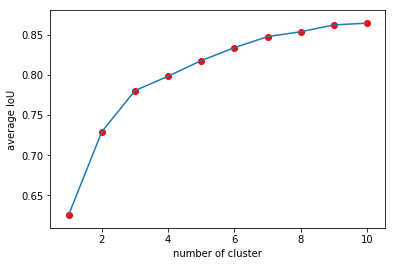

Done!


In [9]:
gen_anchors(n_clusters, uec100_dims)